In [2]:
from prescriptors.nsga2.nsga2_utils import calculate_crowding_distance
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

In [52]:
save_path = Path("prescriptors/nsga2/trained_prescriptors/full")
df = pd.read_csv(save_path / "100.csv")

In [53]:
df

,gen,id,parents,NSGA-II_rank,distance,ELUC,change
0,1,1,"(None, None)",1,inf,0.001004,0.005342
1,79,29,"((71, 7), (71, 99))",1,inf,-17.597390,0.292492
2,22,36,"((4, 48), (4, 48))",1,0.174630,-2.310731,0.049346
3,90,79,"((86, 32), (44, 98))",1,0.146467,-17.597387,0.292492
4,85,50,"((64, 10), (78, 4))",1,0.086227,-17.597357,0.292491
...,...,...,...,...,...,...,...
95,83,37,"((27, 16), (28, 48))",1,0.018410,-13.760078,0.176510
96,99,22,"((79, 29), (96, 88))",1,0.018242,-17.292807,0.285113
97,99,35,"((98, 89), (88, 90))",1,0.018166,-17.552963,0.291309
98,99,16,"((90, 26), (94, 62))",1,0.018053,-17.143616,0.279503


In [54]:
class DummyCandidate():
    def __init__(self, gen, id, eluc, change):
        self.gen = gen
        self.id = id
        self.metrics = [eluc, change]

In [55]:
candidates = []
for idx, row in df.iterrows():
    candidate = DummyCandidate(row["gen"], row["id"], row["ELUC"], row["change"])
    candidates.append(candidate)

In [56]:
calculate_crowding_distance(candidates)

In [57]:
sorted_candidates = sorted(candidates, key=lambda x: x.distance, reverse=True)

In [58]:
for candidate in sorted_candidates:
    print(candidate.gen, candidate.id, candidate.metrics, candidate.distance)

1 1 [0.0010039111, 0.0053418109681371] inf
79 29 [-17.59739, 0.2924915500928172] inf
22 36 [-2.3107312, 0.0493462470382068] 0.32109647150094855
79 65 [-7.4361663, 0.0980785518025625] 0.11732669970562576
20 82 [-4.668536, 0.0748326494271499] 0.11684793387665791
16 80 [-8.687402, 0.1040248441419088] 0.10986313844407089
84 2 [-5.4718056, 0.078336737779323] 0.10724040060460814
27 37 [-6.4164877, 0.0888808819679852] 0.10546032144750017
69 22 [-2.5765672, 0.0554868278221834] 0.0993053250266182
85 28 [-3.182488, 0.0636374507143332] 0.09748822203564779
71 98 [-9.409938, 0.1114119414895223] 0.09742143932416744
81 71 [-11.550789, 0.1361033235777788] 0.09670978848401535
27 16 [-12.488137, 0.1415340640282819] 0.09534591238591883
72 84 [-5.9912844, 0.0840436614463082] 0.090400037978054
45 71 [-7.202611, 0.0945615731061868] 0.08997248985479908
83 34 [-3.9543705, 0.0695435919695925] 0.08875638270410396
79 44 [-13.13078, 0.1595109228637566] 0.08221777516905254
71 21 [-9.959371, 0.1164295997383715] 0.0

In [59]:
from pathlib import Path
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = Path(dir) / f"{gen}.csv"
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen:int, results_dir: Path):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_path = results_dir / f"{gen}.csv"      
        gen_df = pd.read_csv(gen_path)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():            
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)

In [60]:
overall_pareto = get_overall_pareto_df(100, Path("prescriptors/nsga2/trained_prescriptors/full"))

In [61]:
sorted_pareto = overall_pareto.sort_values(by="change", ascending=True)

In [62]:
copy_path = Path("prescriptors/nsga2/trained_prescriptors/demo")
copy_path.mkdir(parents=True, exist_ok=True)

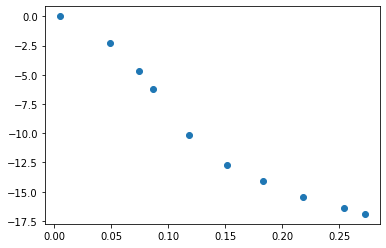

In [63]:
indices = [0, 1, 7, 10, 20, 30, 40, 60, 80, 99]
selected_cands = sorted_pareto.iloc[indices]
plt.scatter(selected_cands["change"], selected_cands["ELUC"])
plt.savefig(copy_path / "pareto_front.png")

In [64]:
selected_cands

,gen,id,parents,NSGA-II_rank,distance,ELUC,change
0,1,1,"(None, None)",1,inf,0.001004,0.005342
1,22,36,"((4, 48), (4, 48))",1,0.237669,-2.310731,0.049346
6,20,82,"((15, 71), (14, 63))",1,0.111395,-4.668536,0.074833
92,98,48,"((1, 1), (71, 98))",1,0.016846,-6.234456,0.086398
53,68,15,"((39, 38), (37, 48))",1,0.026081,-10.162160,0.118339
12,29,94,"((28, 54), (22, 6))",1,0.088717,-12.714643,0.151653
22,76,78,"((52, 73), (52, 73))",1,0.040124,-14.101800,0.182827
96,81,85,"((69, 90), (61, 67))",1,0.016929,-15.416994,0.218190
99,51,85,"((41, 13), (38, 83))",1,0.012660,-16.385780,0.254588
95,55,26,"((54, 86), (48, 95))",1,0.013901,-16.896957,0.272216


In [65]:
for idx, row in selected_cands.iterrows():
    gen = row["gen"]
    id = row["id"]
    suffix = f"{gen+1}/{gen}_{id}.pt"
    cand_path = save_path / suffix
    (copy_path / str(gen+1)).mkdir(parents=True, exist_ok=True)
    shutil.copy2(cand_path, copy_path / suffix)

In [66]:
selected_cands.to_csv(copy_path / "pareto.csv", index=False)